In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as split
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore as zs
from keras.layers import Dense , Dropout , LSTM , GRU
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import warnings
from warnings import filterwarnings
filterwarnings('ignore')



In [487]:
!pip install  pmdarima 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [488]:
from pmdarima import auto_arima

In [489]:
df=pd.read_excel("/content/combined_data_copy.xlsx")

In [490]:
df.head(5)

,Date,Gold,Crude Oil,Natural Gas
0,"Sep 30, 2019",1469.2,50.03,2.330
1,"Sep 30, 2016",1315.1,48.24,2.906
2,"Sep 30, 2015",1115.5,45.09,2.524
3,"Sep 30, 2014",1366.7,91.16,4.121
4,"Sep 30, 2013",1326.5,102.33,3.560


# **DATA DESCRIPTION** 
**Source of Data Collection**:Individual Data series collected from (https://in.investing.com/) between June 2000 to  June 2020.

**DATA DIMENSION:-**

--> 5001 attributes
--> 4 features

**FEATURES:-**
Dates
Gold Price
Crude Oil Price
Natural Gas Price

Features has been selected after combining individual data of different features into one with only price factors using VLOOKUP function in excel



In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5000 non-null   object 
 1   Gold         5000 non-null   float64
 2   Crude Oil    4992 non-null   float64
 3   Natural Gas  4990 non-null   float64
dtypes: float64(3), object(1)
memory usage: 156.4+ KB


In [492]:
#During preprocessing we need to change the Date into DateTime
#We need to make Date column index

df.describe()

,Gold,Crude Oil,Natural Gas
count,5000.000000,4992.000000,4990.000000
mean,960.413264,62.010785,4.638786
std,460.393428,25.906349,2.248465
min,255.100000,17.450000,1.639000
25%,437.200000,43.447500,2.935250
50%,1117.250000,56.035000,3.991000
75%,1312.325000,83.190000,5.782000
max,1888.700000,145.290000,15.378000


In [493]:
#Finding for any missing values

df.isnull().sum()

Date            0
Gold            0
Crude Oil       8
Natural Gas    10
dtype: int64

In [494]:
#Now we have to fill the missing values with previous day data

df=df.fillna(method="ffill")
df.isnull().sum()

Date           0
Gold           0
Crude Oil      0
Natural Gas    0
dtype: int64

In [495]:
df.columns



Index(['Date', 'Gold ', 'Crude Oil', 'Natural Gas'], dtype='object')

# EXTRACTING FEATURES OF DATAS 

To change the date format:-

-->we need to change the data into numbers

-->make different columns 

-->merge the columns after changing the format




In [496]:
def change_into_datetime(col):
    df[col]=pd.to_datetime(df[col])


In [497]:
for i in ['Date']:
    change_into_datetime(i)

In [498]:
df.dtypes

Date           datetime64[ns]
Gold                  float64
Crude Oil             float64
Natural Gas           float64
dtype: object

In [499]:
df['day']=df['Date'].dt.day
df['month']=df['Date'].dt.month
df['year']=df['Date'].dt.year

In [500]:

df.head(5)

,Date,Gold,Crude Oil,Natural Gas,day,month,year
0,2019-09-30,1469.2,50.03,2.330,30,9,2019
1,2016-09-30,1315.1,48.24,2.906,30,9,2016
2,2015-09-30,1115.5,45.09,2.524,30,9,2015
3,2014-09-30,1366.7,91.16,4.121,30,9,2014
4,2013-09-30,1326.5,102.33,3.560,30,9,2013


In [501]:
df.drop('Date',axis=1,inplace=True)


In [502]:
df.head(5)

,Gold,Crude Oil,Natural Gas,day,month,year
0,1469.2,50.03,2.330,30,9,2019
1,1315.1,48.24,2.906,30,9,2016
2,1115.5,45.09,2.524,30,9,2015
3,1366.7,91.16,4.121,30,9,2014
4,1326.5,102.33,3.560,30,9,2013


In [503]:
df['Date']=df['day'].astype(str)+'-'+df['month'].astype(str)+'-'+df['year'].astype(str)
df.head(10)

,Gold,Crude Oil,Natural Gas,day,month,year,Date
0,1469.2,50.03,2.330,30,9,2019,30-9-2019
1,1315.1,48.24,2.906,30,9,2016,30-9-2016
2,1115.5,45.09,2.524,30,9,2015,30-9-2015
3,1366.7,91.16,4.121,30,9,2014,30-9-2014
4,1326.5,102.33,3.560,30,9,2013,30-9-2013
5,1620.4,79.20,3.666,30,9,2011,30-9-2011
6,1307.8,79.97,3.872,30,9,2010,30-9-2010
7,1008.0,70.61,4.841,30,9,2009,30-9-2009
8,874.2,100.64,7.438,30,9,2008,30-9-2008
9,469.0,66.24,13.921,30,9,2005,30-9-2005


In [504]:
df=df.sort_values('year',ascending=True)
df.head(100)

,Gold,Crude Oil,Natural Gas,day,month,year,Date
2323,289.6,32.95,4.463,15,6,2000,15-6-2000
4056,272.2,28.44,8.584,8,12,2000,8-12-2000
2890,283.2,29.99,4.066,6,7,2000,6-7-2000
2238,285.8,31.37,4.378,21,6,2000,21-6-2000
415,277.0,33.38,4.835,1,9,2000,1-9-2000
...,...,...,...,...,...,...,...
3870,273.7,25.98,9.830,21,12,2000,21-12-2000
39,275.6,30.34,5.124,28,9,2000,28-9-2000
2805,280.4,30.32,4.031,12,7,2000,12-7-2000
2690,279.8,30.93,3.860,20,7,2000,20-7-2000


In [505]:
df.drop('day',axis=1,inplace=True) 
df.drop('month',axis=1,inplace=True) 
df.drop('year',axis=1,inplace=True)

In [506]:
df.head()

,Gold,Crude Oil,Natural Gas,Date
2323,289.6,32.95,4.463,15-6-2000
4056,272.2,28.44,8.584,8-12-2000
2890,283.2,29.99,4.066,6-7-2000
2238,285.8,31.37,4.378,21-6-2000
415,277.0,33.38,4.835,1-9-2000


In [507]:
##Converting Date column as DateTime format

df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y')

In [508]:
df=df.sort_values('Date',ascending=True)
df.head(100)

,Gold,Crude Oil,Natural Gas,Date
2521,272.5,30.14,4.064,2000-06-01
2507,281.4,30.35,4.043,2000-06-02
2468,285.4,29.70,4.398,2000-06-05
2453,289.0,29.75,4.294,2000-06-06
2437,287.2,29.95,3.945,2000-06-07
...,...,...,...,...
631,271.1,32.99,5.439,2000-10-17
615,270.3,33.48,5.228,2000-10-18
600,270.1,32.91,4.951,2000-10-19
586,271.2,33.75,4.937,2000-10-20


In [509]:
df.dtypes

Gold                  float64
Crude Oil             float64
Natural Gas           float64
Date           datetime64[ns]
dtype: object

In [510]:
##Setting date as index

df.set_index('Date',inplace=True)

In [511]:
df.head(5)

,Gold,Crude Oil,Natural Gas
Date,,,
2000-06-01,272.5,30.14,4.064
2000-06-02,281.4,30.35,4.043
2000-06-05,285.4,29.70,4.398
2000-06-06,289.0,29.75,4.294
2000-06-07,287.2,29.95,3.945


## Exploratory Data Analysis (EDA)

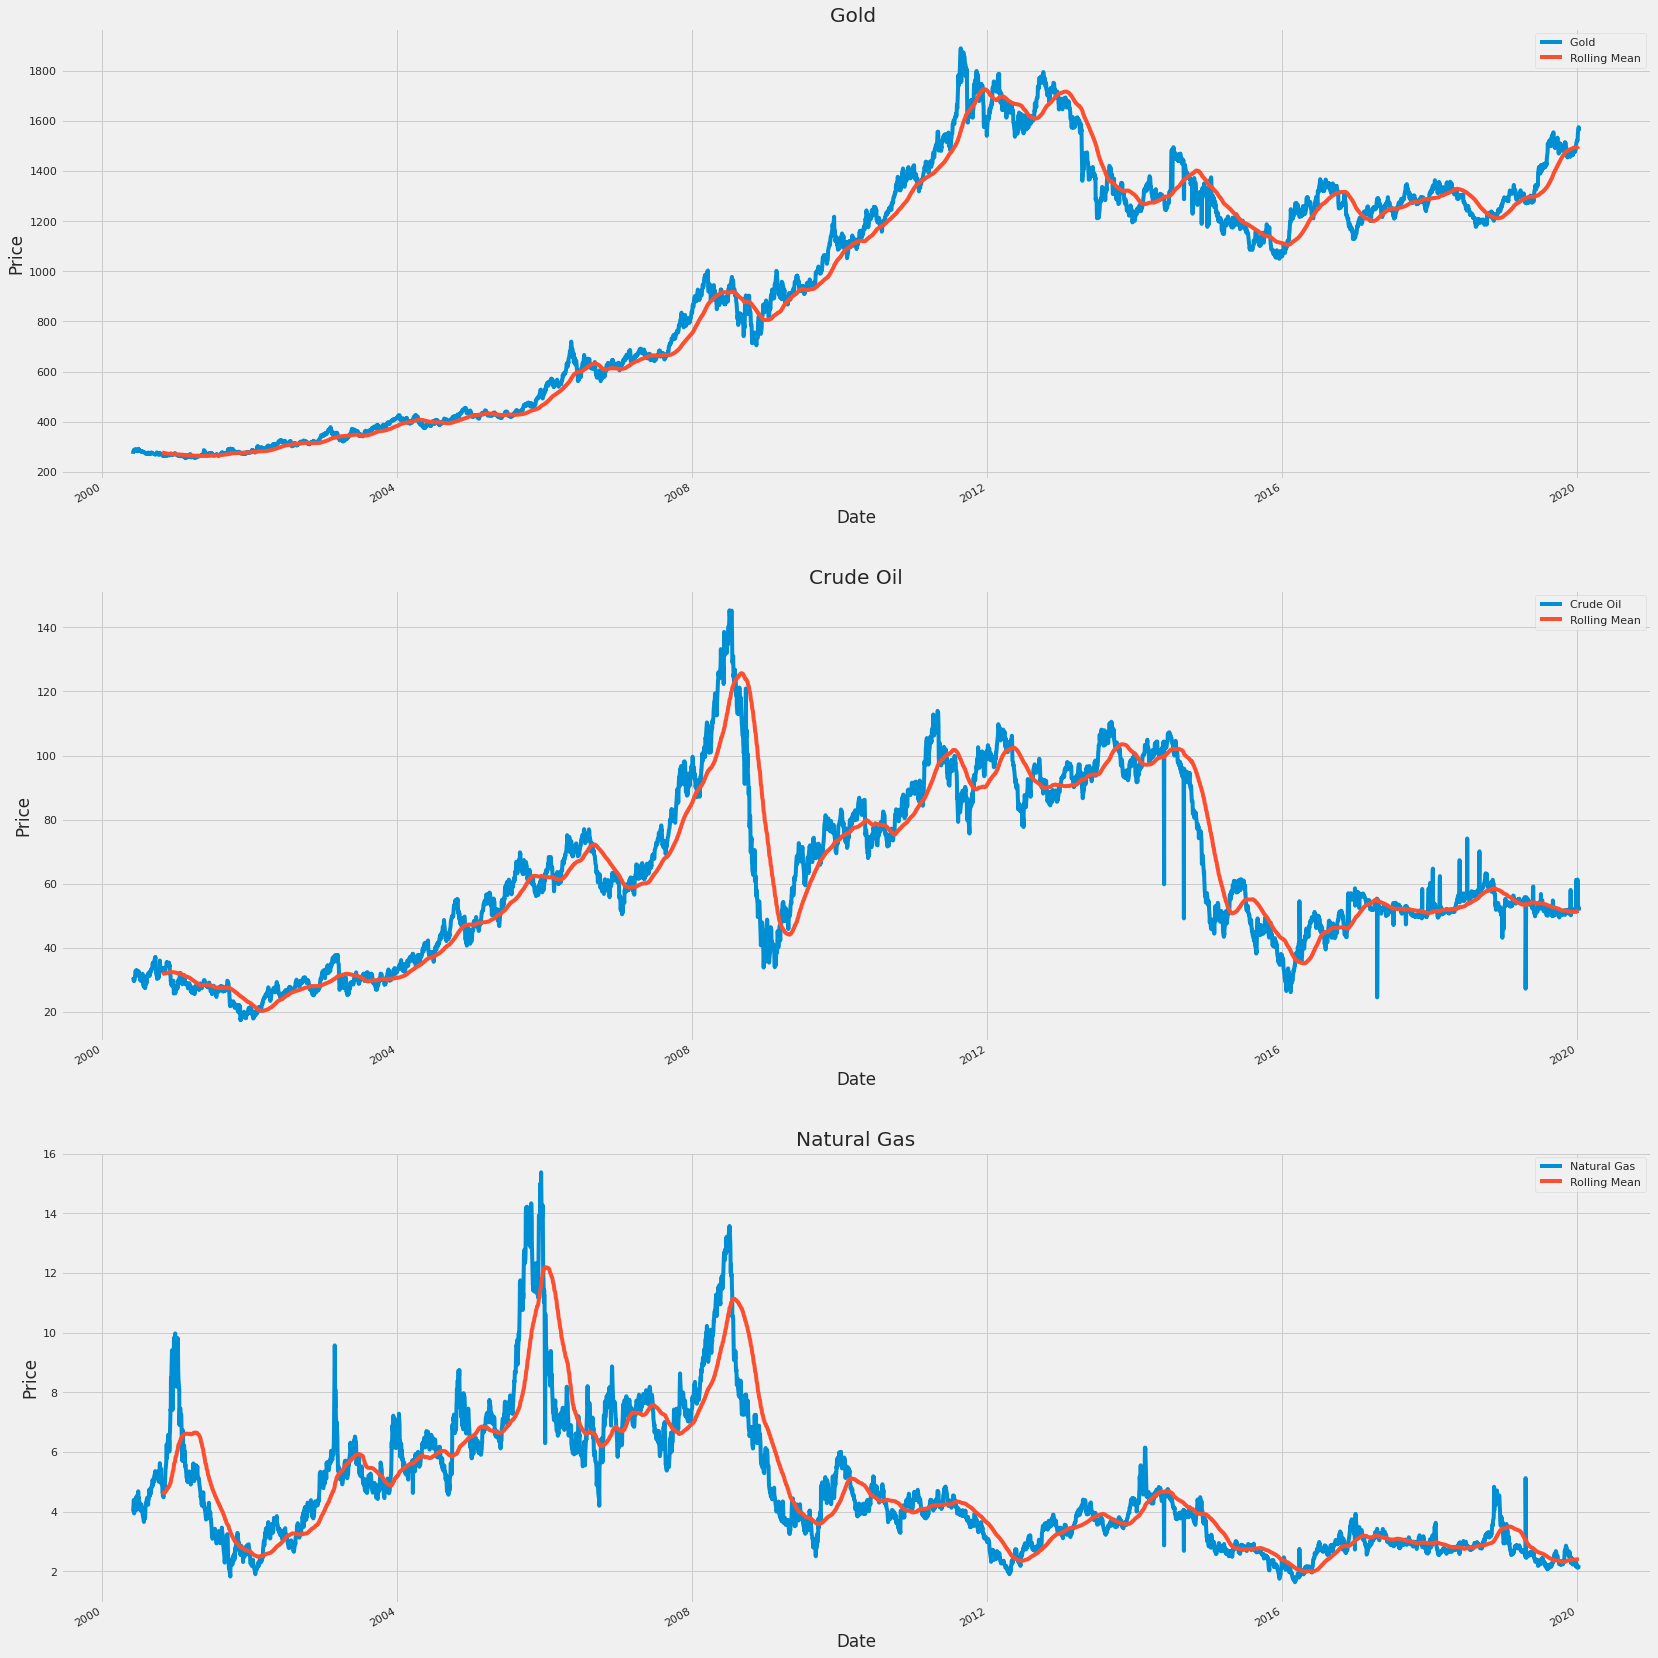

In [512]:
##Line plots target and features
data=df
col_names=data.columns

fig=plt.figure(figsize=(24,24))
plt.style.use('fivethirtyeight')

for i in range(3):
  ax = fig.add_subplot(3,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

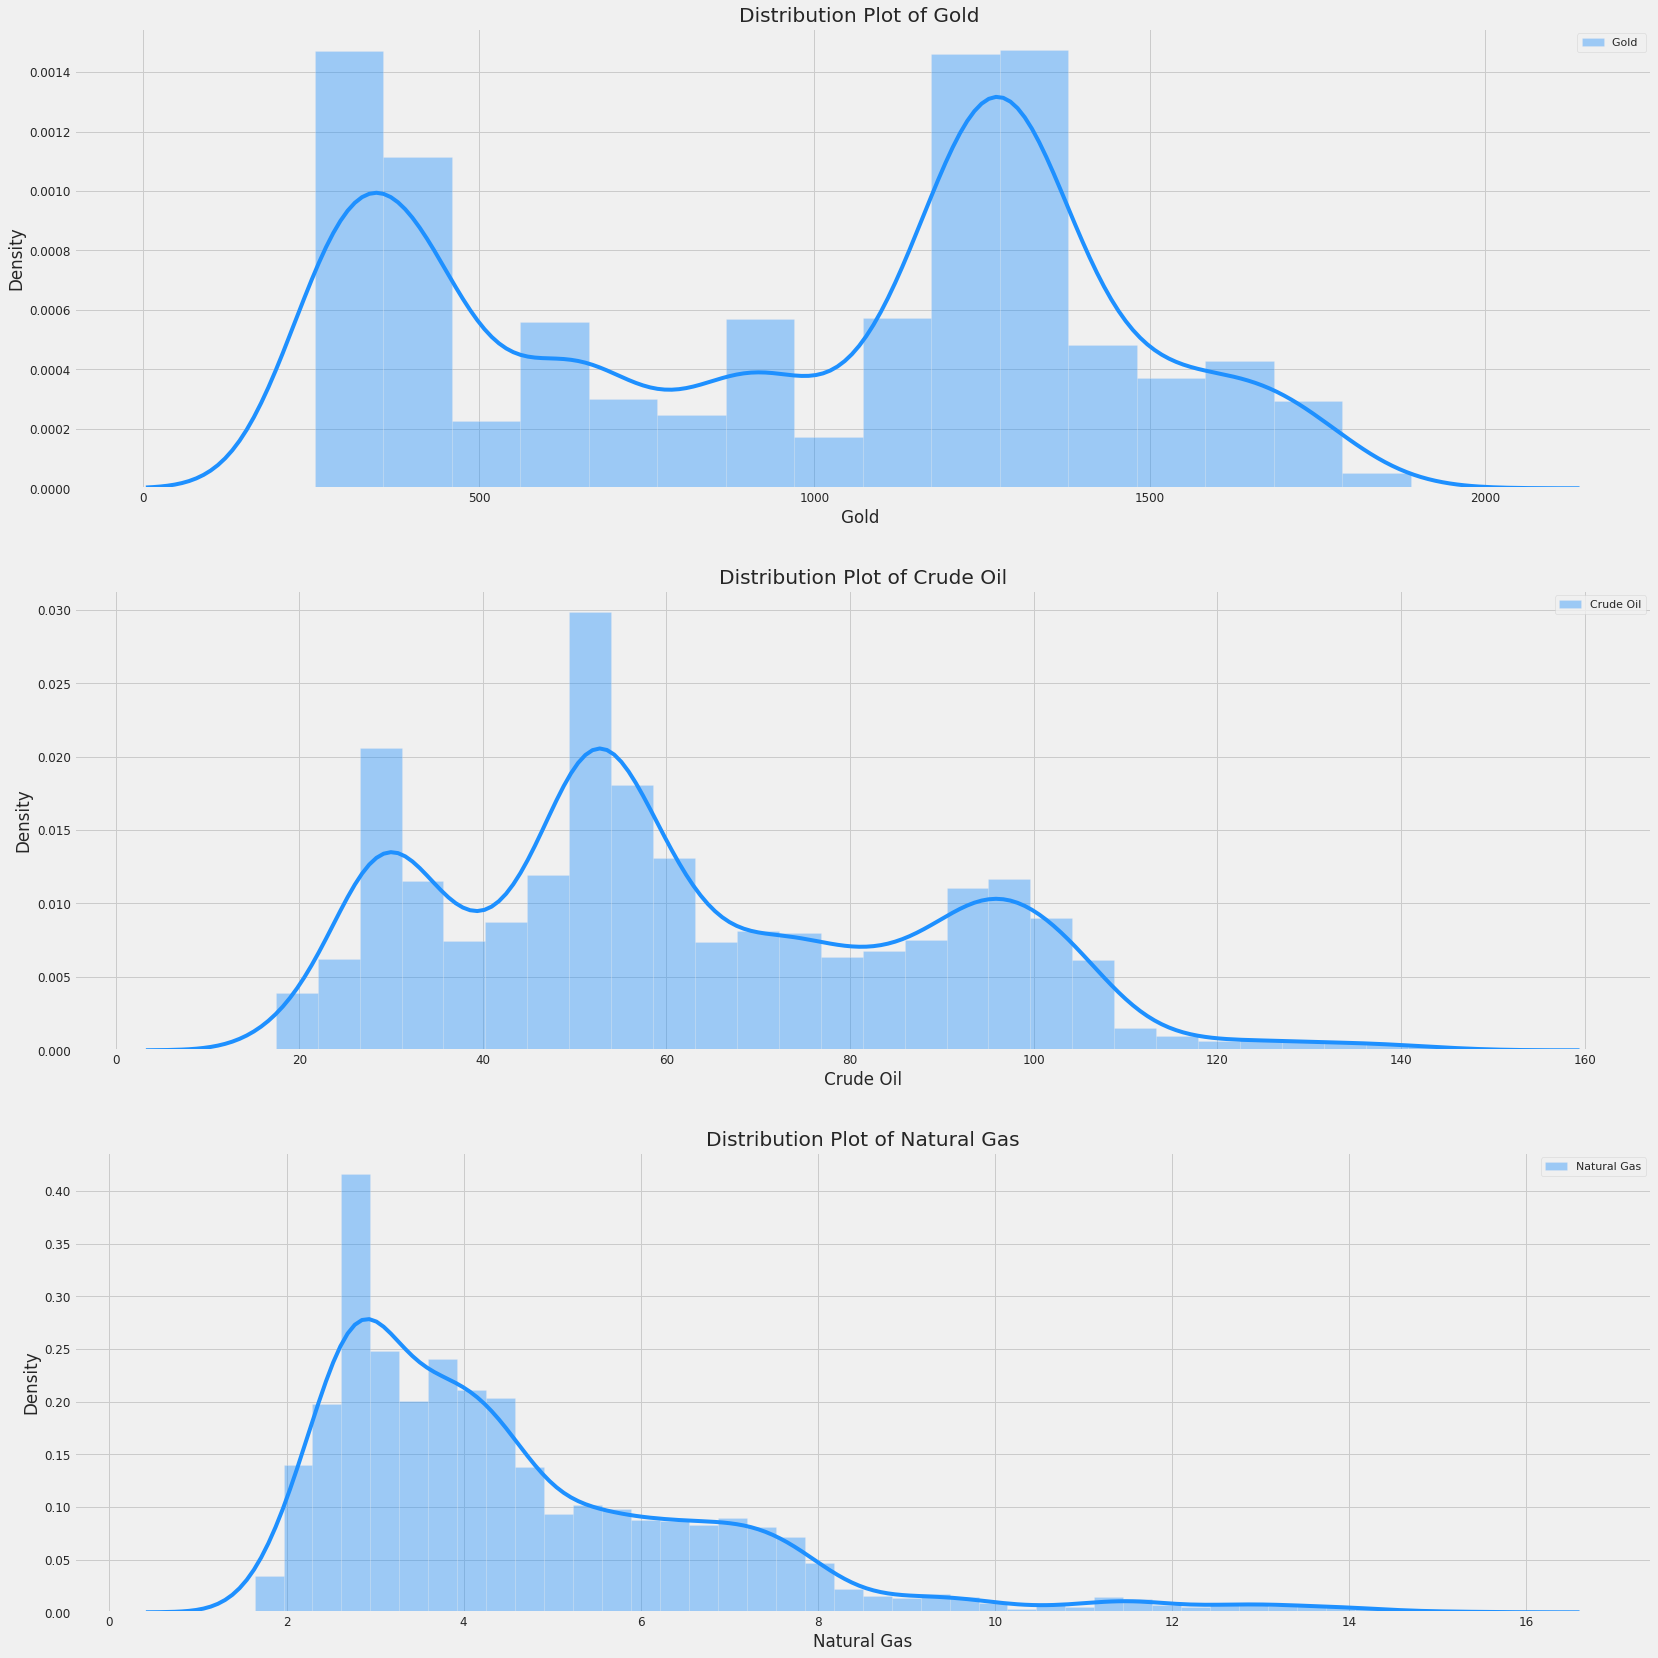

In [513]:
##Checking if Target and Features follow Normal Distribution
data = df
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
col_names = data.columns
for i in range(3):
  ax = fig.add_subplot(3,1,i+1)
  sns.distplot(data.iloc[:,i],label=col_names[i],color='dodgerblue').set_title("Distribution Plot of {}".format(col_names[i]),axes=ax)
  ax.tick_params(labelsize=12)
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

In [514]:
##Scaling Data to Observe Bivariate Analysis 
sc = MinMaxScaler(feature_range=(0,1))
df_scaled= sc.fit_transform(df)

Since distribution is not normal we use Standardisation instead of Normalization.

In [515]:
##Scaled Data Glimse
df_scaled[:3]

array([[0.01065132, 0.09926471, 0.17650484],
       [0.01609941, 0.10090738, 0.17497634],
       [0.01854799, 0.0958229 , 0.2008152 ]])

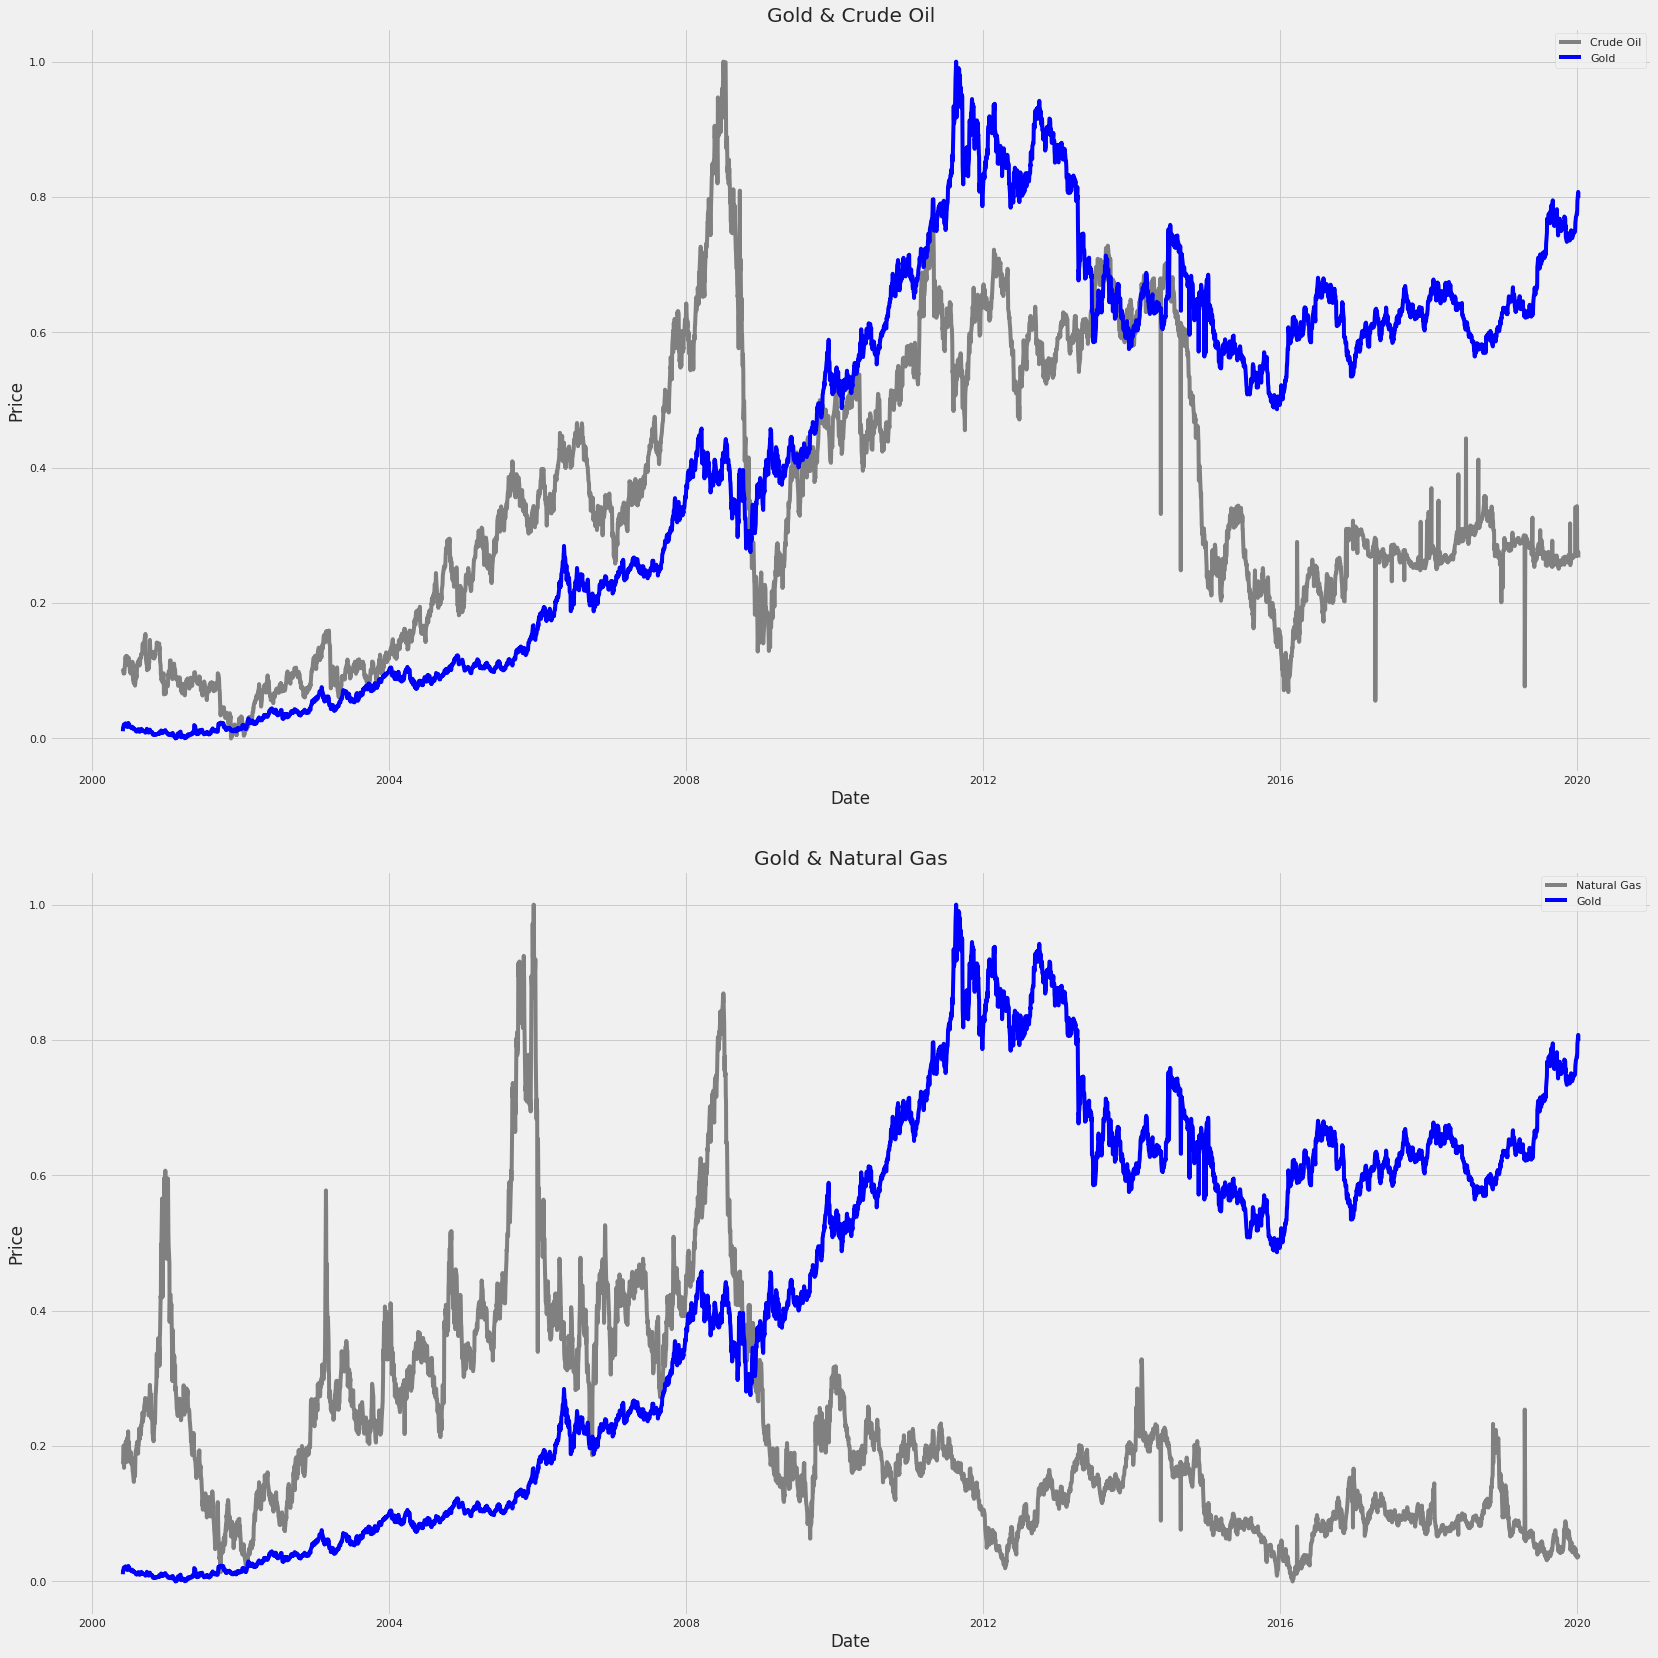

In [516]:
##Comparing Movement of Gold wrt to Features
col_names = data.columns[1:]
scaled_features = df_scaled[:,1:]
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(2):
  ax = fig.add_subplot(2,1,i+1)
  ax.plot(df.index,scaled_features[:,i],label=col_names[i],c='grey')
  ax.plot(df.index,df_scaled[:,0],label='Gold',c='blue')
  ax.set_title('Gold & ' + col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

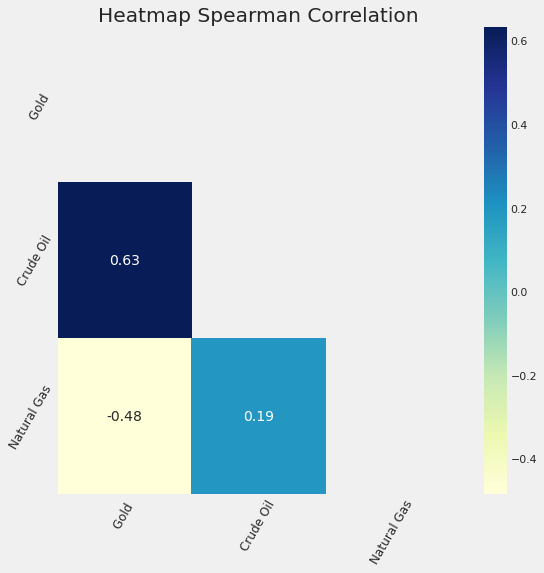

In [517]:
##HeatMap Spearman Correlation
plt.figure(figsize=(8,8))
matrix = np.triu(df.corr(method='spearman'))
heat_map = sns.heatmap(df.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

-> The highest positive correlation with target variable Gold is with Crude Oil(ρ:0.63)

-> We also observe that Natural Gas and Gold have less correlation.(ρ : -0.48) and are inversely correlated

In [518]:
##Spearman Correlation In Tabular Form
df.corr(method='spearman')

,Gold,Crude Oil,Natural Gas
Gold,1.000000,0.631598,-0.484372
Crude Oil,0.631598,1.000000,0.189591
Natural Gas,-0.484372,0.189591,1.000000


In [519]:
##Feature Selection
after_fs = df[['Crude Oil','Natural Gas']]
after_fs.head(10)

,Crude Oil,Natural Gas
Date,,
2000-06-01,30.14,4.064
2000-06-02,30.35,4.043
2000-06-05,29.70,4.398
2000-06-06,29.75,4.294
2000-06-07,29.95,3.945
2000-06-08,29.78,4.133
2000-06-09,30.20,4.160
2000-06-12,31.74,4.212
2000-06-13,32.56,4.158


# Outlier elimination

Financial crisi outlier removal

In [520]:
before_2007 = after_fs['2000-01':'2007-06']
after_2009 = after_fs['2009-06':'2019-06']
fin_out = pd.concat([before_2007,after_2009],axis=0)
fin_out.shape

(4379, 2)

Z-score Outlier removal technique

In [521]:
zscore = np.abs(zs(after_fs['Crude Oil']))
zscore_df = after_fs.copy()
zscore_df['zscore'] = zscore
zscore_df.head(5)

,Crude Oil,Natural Gas,zscore
Date,,,
2000-06-01,30.14,4.064,1.229613
2000-06-02,30.35,4.043,1.221505
2000-06-05,29.70,4.398,1.246603
2000-06-06,29.75,4.294,1.244673
2000-06-07,29.95,3.945,1.236950


In [522]:
#Considering Outliers of more than +-2.5 zscore as outliers
len(zscore_df[zscore_df['zscore']>2.5])

43

In [523]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2.5,['Crude Oil','Natural Gas']]
zscore_df.shape

(4957, 2)

# Data Preparation for Modelling

**Train-Test-Split**

In [524]:
fin_train,fin_test = split(fin_out,train_size=0.7,shuffle=False)
z_train,z_test = split(zscore_df,train_size=0.7,shuffle=False)
mah_train,mah_test = split(mah_df,train_size=0.7,shuffle=False)
van_train,van_test = split(after_fs,train_size=0.7,shuffle=False)

In [525]:
print('Fin Outlier Dataset')
print(fin_train.shape)
print(fin_test.shape)
print('Zscore Dataset')
print(z_train.shape)
print(z_test.shape)

Fin Outlier Dataset
(3065, 2)
(1314, 2)
Zscore Dataset
(3469, 2)
(1488, 2)


In [526]:
#We need 2 scalers per model -Train and Test require different scalers
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

In [527]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.09926471],
       [0.10090738],
       [0.0958229 ],
       ...,
       [0.27354506],
       [0.27573529],
       [0.26736546]])

In [528]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.09926471, 0.10090738, 0.0958229 , 0.09621402, 0.09777847,
       0.09644869, 0.09973404, 0.11178035, 0.11819462, 0.12046308,
       0.12124531, 0.11639549, 0.11138924, 0.12202753, 0.10888611,
       0.11530038, 0.11576971, 0.1109199 , 0.11428348, 0.11303191,
       0.11944618, 0.11772528, 0.10341051, 0.09809136, 0.10035982,
       0.09574468, 0.0958229 , 0.10067272, 0.10966834, 0.10912078,
       0.10466208, 0.11334481, 0.10927722, 0.10544431, 0.08690551,
       0.08268148, 0.08213392, 0.0810388 , 0.08268148, 0.08393304,
       0.07806633, 0.08088235, 0.08455882, 0.08768773, 0.0978567 ,
       0.0896433 , 0.09128598, 0.10090738, 0.10865144, 0.10614831,
       0.11334481, 0.11123279, 0.11224969, 0.11334481, 0.11373592,
       0.11749061, 0.10771277, 0.11397059, 0.1109199 , 0.11404881])]
[0.12061952440550688]

[array([0.09926471, 0.10090738, 0.0958229 , 0.09621402, 0.09777847,
       0.09644869, 0.09973404, 0.11178035, 0.11819462, 0.12046308,
       0.12124531, 0.11639549, 0.11

In [529]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)


In [530]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4440, 60, 1)

# Long Short-Term Memory Networks(LSTM)

In [531]:

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [532]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [533]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

4440/4440 [==============================] - 177s 39ms/step - loss: 0.0011


In [534]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [535]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [536]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [537]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [538]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2.6540970265561925

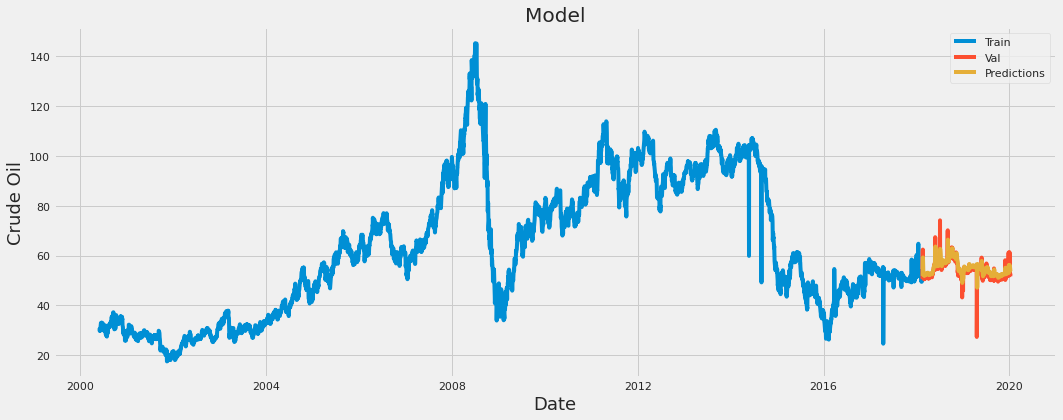

In [539]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Crude Oil', fontsize=18)
plt.plot(train['Crude Oil'])
plt.plot(valid[['Crude Oil', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

# XGBOOST SIMPLE AUTOARIMA FOR FORECASTING


In [540]:
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


import shapely

In [541]:
import shap
import time
from scipy import sparse
import sys
import os

In [542]:
df.shape
df.head()

,Gold,Crude Oil,Natural Gas
Date,,,
2000-06-01,272.5,30.14,4.064
2000-06-02,281.4,30.35,4.043
2000-06-05,285.4,29.70,4.398
2000-06-06,289.0,29.75,4.294
2000-06-07,287.2,29.95,3.945


# TRAIN MODEL

In [543]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle

In [567]:
from operator import index
x=df.drop('Crude Oil',axis=1)
y=df['Crude Oil']


In [545]:
x.head()


,Gold,Natural Gas
Date,,
2000-06-01,272.5,4.064
2000-06-02,281.4,4.043
2000-06-05,285.4,4.398
2000-06-06,289.0,4.294
2000-06-07,287.2,3.945


In [546]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [547]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)

In [548]:
# import XGBClassifier
from xgboost import XGBClassifier

In [549]:
# declare parameters
'''params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
            
            
            
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)



# fit the classifier to the training data
xgb_clf.fit(x_train,df.sort_index(ascending=True))'''

"params = {\n            'objective':'binary:logistic',\n            'max_depth': 4,\n            'alpha': 10,\n            'learning_rate': 1.0,\n            'n_estimators':100\n        }\n            \n            \n            \n# instantiate the classifier \nxgb_clf = XGBClassifier(**params)\n\n\n\n# fit the classifier to the training data\nxgb_clf.fit(x_train,df.sort_index(ascending=True))"

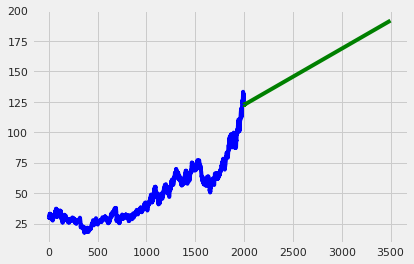

KeyError: ignored

In [597]:
y=y_train.sort_index(ascending=True)
train, test = train_test_split(y, train_size=2000)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future
test['Forecast_ARIMA']=forecasts

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:2000], train, c='blue')
plt.plot(x[2000:], forecasts, c='green')
plt.show()
y[['Crude Oil','Forecast_ARIMA']].plot(figsize=(16,7))

In [553]:
# Load/split your data
y = y_train
train, test = train_test_split(y, train_size=110)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m=12,
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=184.918, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=188.802, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=188.796, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=183.003, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=186.806, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=186.800, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=188.784, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=186.903, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=186.903, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 4.027 seconds


Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=12, trace=True))])

# TRAINING SET AND TESTING SET 


In [554]:
'''XB = xgb.XGBClassifier()
XB.fit(x_train,y_train)

predicted_values = XB.predict(x_test)

x = metrics.accuracy_score(y_test, predicted_values)
acc.append(x)
model.append('XGBoost')
print("XGBoost's Accuracy is: ", x)

print(classification_report(y_test,predicted_values))'''

'XB = xgb.XGBClassifier()\nXB.fit(x_train,y_train)\n\npredicted_values = XB.predict(x_test)\n\nx = metrics.accuracy_score(y_test, predicted_values)\nacc.append(x)\nmodel.append(\'XGBoost\')\nprint("XGBoost\'s Accuracy is: ", x)\n\nprint(classification_report(y_test,predicted_values))'

In [555]:
from pmdarima import auto_arima

In [577]:
ind_feature=['Natural Gas']

In [557]:
training_data=df[0:1800]
test_data=df[1800:0]

In [588]:
model=auto_arima(y=training_data['Crude Oil'],exogenous=training_data[ind_feature],trace=True)

ValueError: ignored

In [589]:
model.fit(training_data['Crude Oil'],training_data[ind_feature])

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [590]:
import warnings
warnings.filterwarnings('ignore')

In [591]:

forecast=model.predict(n_periods=len(test_data),exogenous=test_data[ind_feature])

ValueError: ignored

In [592]:
test_data['Forecast_ARIMA']=forecasts

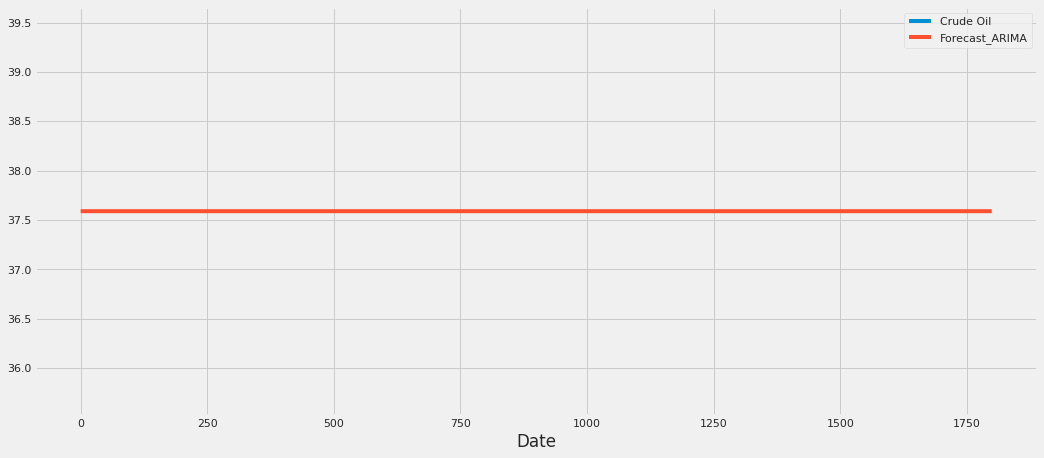

In [593]:
test_data[['Crude Oil','Forecast_ARIMA']].plot(figsize=(16,7))